# Experiment

Dataset: GeoLife dataset discretized on 100 clusters and 30 minute interval.

## Requirements

- Pre-processed dataset located at `{ROOT}/data/geolife-c100`
- Pre-computed 100 clusters located at `{ROOT}/data/exploratory_analysis/geolife_mog_100.npy`

## Import and constants

In [1]:
import pandas as pd
import numpy as np
import math
import tqdm
import matplotlib.pyplot as plt
import os
import datetime
import random
import folium

## define dataset

### define path

Change the path variable here if you place your dataset files in a different location.

In [2]:
from src.path import ROOT

dataset_path = str(ROOT.joinpath('data/geolife-c100'))
cluster_path = f'{ROOT}/exploratory_analysis/geolife_mog_100.npy'

### get week with most persistent users

In [3]:
from src.utils import set_intersect
from collections import deque

sets: deque[set[str]] = deque()

fnames = os.listdir(dataset_path)

def get_date(fname: str) -> datetime.date:
    fname = fname[:fname.index('.')]
    year, month, day = fname.split('-')
    return (int(year), int(month), int(day))

fnames = sorted(fnames, key=get_date)

prev_date = None
max_count = 0
max_date = None

for i in tqdm.trange(len(fnames)):
    d = get_date(fnames[i])
    curr_date = datetime.date(year=d[0], month=d[1], day=d[2])

    df = pd.read_csv(f'{dataset_path}/{fnames[i]}', dtype={ 'uid': str, 't': int, 'lat': np.float64, 'long': np.float64 })

    if len(sets) >= 7:
        sets.popleft()

    if prev_date != None and (curr_date - prev_date).days > 1:
        sets = []

    sets.append(set(df['uid'].unique().tolist()))

    if len(sets) == 7:
        curr_count = len(set_intersect(*sets))

        if curr_count > max_count:
            max_count = curr_count
            max_date = curr_date
    
    prev_date = curr_date

print(max_count)
print(max_date)

100%|██████████| 4591/4591 [00:05<00:00, 835.97it/s] 

46
2009-02-19


### load dataset

Load dataset files into in-memory.

In [4]:
start_date = datetime.date(year=2009, month=2, day=13)
test_files = []

for i in range(7):
    curr_date = start_date + datetime.timedelta(days=i)
    test_files.append(f'{curr_date.year}-{curr_date.month}-{curr_date.day}.csv')

### read basestations

In [5]:
all_candidates: np.ndarray = np.load(cluster_path)

In [6]:
from src.data_preprocess.trajectory import from_dataframe, Trajectory

SEQ_LENGTH = 48

def read_csv(fname: str):
    # https://stackoverflow.com/questions/36909368/precision-lost-while-using-read-csv-in-pandas#:~:text=Pandas%20uses%20a%20dedicated%20decimal-to-binary%20converter%20that%20sacrifices,of%20speed.%20Passing%20float_precision%3D%27round_trip%27%20to%20read_csv%20fixes%20this.
    df = pd.read_csv(f'{dataset_path}/{fname}', float_precision='round_trip', dtype={ 'uid': str, 't': int, 'lat': np.float64, 'long': np.float64 })
    return from_dataframe(df, SEQ_LENGTH)

test_trajectories: list[dict[str, Trajectory]] = [None] * len(test_files)

for i in tqdm.trange(len(test_files)):
    fname = test_files[i]
    test_trajectories[i] = read_csv(fname)

100%|██████████| 7/7 [00:00<00:00, 23.98it/s]


Optional: remove non-persistent users

In [7]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

for i in range(len(test_trajectories)):
    test_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

46

## baseline

#### define metric

In [8]:
from src.main.baseline import RecoveryFromAshDistance

ref_lat = np.median(all_candidates[:, 0]).item()
ref_long = np.median(all_candidates[:, 1]).item()

day_timestamp = 12

distance_metric = RecoveryFromAshDistance(ref=(ref_lat, ref_long), day_time=day_timestamp)

#### night time trajectory recovery

In [9]:
from src.main.baseline import DailyTrajectoryRecovery, get_aggregated_observations

predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night time recovery'):
    trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=day_timestamp,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night time recovery: 100%|██████████| 7/7 [00:00<00:00, 252.67it/s]


Evaluate

In [10]:
from src.eval.metrics import greedy_match, similarity, mean_distance

avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 7/7 [00:00<00:00, 981.29it/s]

average accuracy: 0.937111801242236
average recovery error: 0.4135120889821508


Visualize predicted trajectories

In [11]:
from src.plot import get_beijing_map, plot_trajectory

bucket_idx = random.randrange(len(test_trajectories))
trajectory_idx = random.randrange(len(test_trajectories[bucket_idx]))

target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[bucket_idx].values()]

indices = greedy_match(predicted[bucket_idx], target_trajectories)

map = get_beijing_map()
fg0=folium.FeatureGroup(name='target', show=True)
fg1=folium.FeatureGroup(name='predicted', show=True)

map.add_child(fg0)
map.add_child(fg1)
folium.LayerControl(collapsed=False).add_to(map)

plot_trajectory(target_trajectories[indices[trajectory_idx]], color='red', map=fg0)
plot_trajectory(predicted[bucket_idx][trajectory_idx], color='blue', map=fg1)
map

#### single day trajectory recovery (night time + day time)

In [12]:
predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 7/7 [00:00<00:00, 100.67it/s]


Evaluate

In [13]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [*target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 7/7 [00:00<00:00, 326.66it/s]

average accuracy: 0.8390269151138716
average recovery error: 1.101030200419396


Visualize predicted trajectories

In [14]:
from src.plot import get_beijing_map, plot_trajectory

bucket_idx = random.randrange(len(test_trajectories))
trajectory_idx = random.randrange(len(test_trajectories[bucket_idx]))

target_trajectories = [*test_trajectories[bucket_idx].values()]

indices = greedy_match(predicted[bucket_idx], target_trajectories)

map = get_beijing_map()
fg0=folium.FeatureGroup(name='target', show=True)
fg1=folium.FeatureGroup(name='predicted', show=True)

map.add_child(fg0)
map.add_child(fg1)
folium.LayerControl(collapsed=False).add_to(map)

plot_trajectory(target_trajectories[indices[trajectory_idx]], color='red', map=fg0)
plot_trajectory(predicted[bucket_idx][trajectory_idx], color='blue', map=fg1)
map

### cross-day trajectory recovery

In [15]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

persistent_trajectories: list[dict[str, Trajectory]] = [None] * len(test_trajectories)

for i in range(len(test_trajectories)):
    persistent_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

46

single day trajectory recovery

In [16]:
predicted: list[list[Trajectory]] = [None] * len(persistent_trajectories)

for i in tqdm.trange(0, len(persistent_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in persistent_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 7/7 [00:00<00:00, 83.80it/s]


cross-day recovery

In [17]:
from src.main.baseline import CrossDayTrajectoryRecovery

algorithm = CrossDayTrajectoryRecovery(predicted)
algorithm.run()

predicted_trajectories = algorithm.result

cross-day recovery: 100%|██████████| 6/6 [00:00<00:00,  7.23it/s]


Evaluate

average accuracy: 0.6998576604554865
average recovery error: 2.424437521961696


Text(0.5, 0, 'recovery error (km)')

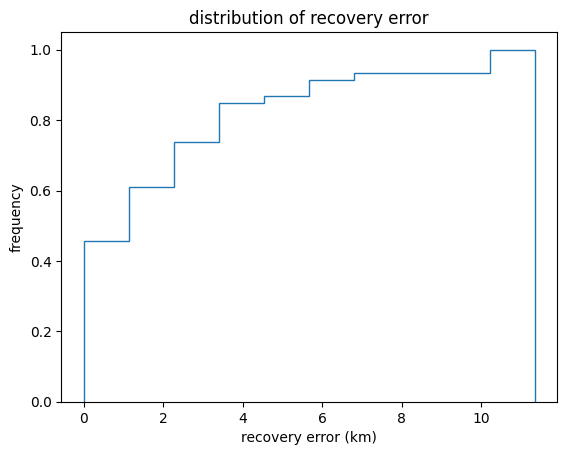

In [18]:
import copy
from src.eval.metrics import similarity, mean_distance

# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

indices = greedy_match(predicted_trajectories, target_trajectories)

accuracy = similarity(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances = mean_distance(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances, cumulative=True, density=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

[0.41304347826086957, 0.8913043478260869, 0.9347826086956522, 0.9347826086956522, 0.9347826086956522]


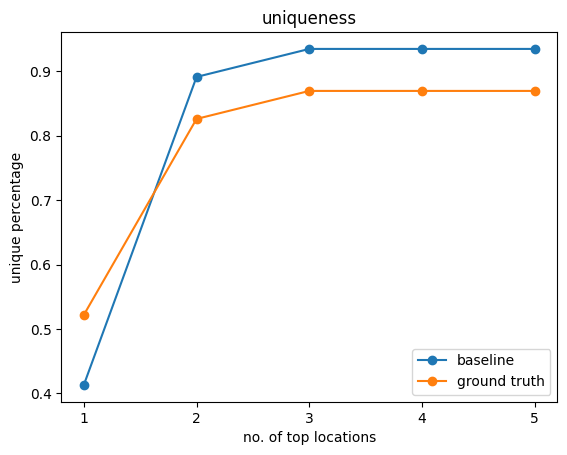

In [19]:
from src.eval.metrics import uniqueness_list

uniqueness = [uniqueness_list(predicted_trajectories, i + 1) for i in range(5)]
print(uniqueness)

# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

ground_truth_uniqueness = [uniqueness_list(target_trajectories, i + 1) for i in range(5)]


plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o', label='baseline')
plt.plot([str(i + 1) for i in range(5)], ground_truth_uniqueness, marker='o', label='ground truth')

plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')
plt.legend()

Visualize predicted trajectories

In [20]:
from src.plot import get_beijing_map, plot_trajectory

trajectory_idx = random.randrange(len(target_trajectories))

map = get_beijing_map()
fg0=folium.FeatureGroup(name='target', show=True)
fg1=folium.FeatureGroup(name='predicted', show=True)

map.add_child(fg0)
map.add_child(fg1)
folium.LayerControl(collapsed=False).add_to(map)

plot_trajectory(target_trajectories[indices[trajectory_idx]], color='red', map=fg0)
plot_trajectory(predicted_trajectories[trajectory_idx], color='blue', map=fg1)
map

## Baseline (no merge)

Since GeoLife is continuous after interpolation. Instead of entropy based cross-day merging, we can just repeat step-1 and step-2 to add points in the next day.

#### define metric

In [21]:
from src.main.baseline import RecoveryFromAshDistance

class MyDistance(RecoveryFromAshDistance):
    def compute(self, trajectories: np.ndarray, candidates: np.ndarray, tstamp: int) -> np.ndarray:
        '''
        compute cost matrix

        Args:
        ---
        - trajectories: [n1, L, (lat, long)]
        - candidates: [n2, (lat, long)]
        - tstamp: timestamp

        Returns:
        ---
        - cost matrix [n1, n2]
        '''
        if (tstamp % SEQ_LENGTH) < self.day_time:
            return self.night_time_distance(trajectories, candidates)
        else:
            return self.day_time_distance(trajectories, candidates)

ref_lat = np.median(all_candidates[:, 0]).item()
ref_long = np.median(all_candidates[:, 1]).item()

day_timestamp = 12

distance_metric = MyDistance(ref=(ref_lat, ref_long), day_time=day_timestamp)

### merge ground truth trajectories

In [22]:
target_trajectories: dict[str, Trajectory] = dict()

for i in tqdm.trange(0, len(test_trajectories), desc='merge ground truth'):
    for uid in persistent_users:
        if uid not in target_trajectories:
            target_trajectories[uid] = test_trajectories[i][uid].copy()
        else:
            target_trajectories[uid].points += test_trajectories[i][uid].points

target_trajectories: list[Trajectory] = [*target_trajectories.values()]

merge ground truth: 100%|██████████| 7/7 [00:00<?, ?it/s]


### trajectory recovery

In [23]:
from src.main.baseline import DailyTrajectoryRecovery, get_aggregated_observations


algorithm = DailyTrajectoryRecovery(
    get_observations=lambda t: get_aggregated_observations(target_trajectories, t),
    cost_matrix=distance_metric.compute,
    sequence_length=len(target_trajectories[0]),
    sequence_count=len(trajectories)
)

algorithm.run(verbose=False)
predicted = algorithm.get_predicted_trajectories()

evaluate

average accuracy: 0.5393374741200828
average recovery error: 3.504636003530517


Text(0.5, 0, 'recovery error (km)')

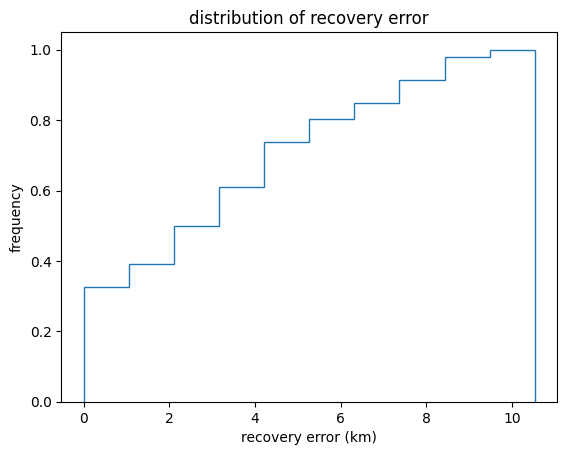

In [24]:
from src.eval.metrics import similarity, mean_distance

indices = greedy_match(predicted, target_trajectories)

accuracy = similarity(
    np.array(predicted),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances = mean_distance(
    np.array(predicted),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances, cumulative=True, density=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

[0.30434782608695654, 0.8260869565217391, 0.9565217391304348, 0.9565217391304348, 0.9565217391304348]


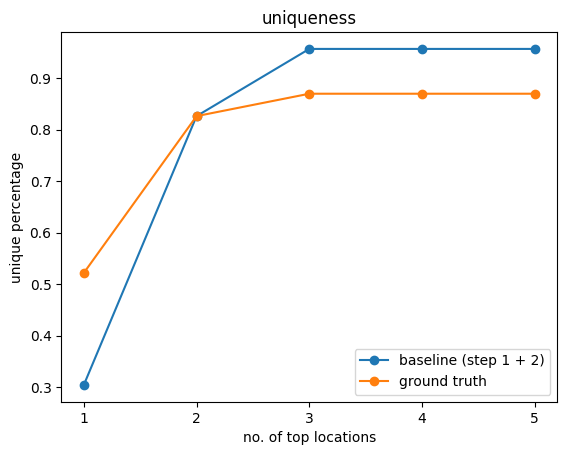

In [25]:
from src.eval.metrics import uniqueness_list

uniqueness = [uniqueness_list(predicted, i + 1) for i in range(5)]
print(uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o', label='baseline (step 1 + 2)')
plt.plot([str(i + 1) for i in range(5)], ground_truth_uniqueness, marker='o', label='ground truth')

plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')
plt.legend()

Surprisingly, performing step-3 can improve accuracy. Maybe step-3 prevents accumulation of error in step-1 and step-2?

Visualize predicted trajectories

In [26]:
from src.plot import get_beijing_map, plot_trajectory

trajectory_idx = random.randrange(len(target_trajectories))

map = get_beijing_map()
fg0=folium.FeatureGroup(name='target', show=True)
fg1=folium.FeatureGroup(name='predicted', show=True)

map.add_child(fg0)
map.add_child(fg1)
folium.LayerControl(collapsed=False).add_to(map)

plot_trajectory(target_trajectories[indices[trajectory_idx]], color='red', map=fg0)
plot_trajectory(predicted[trajectory_idx], color='blue', map=fg1)
map